In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# defining dir variables 
train_defective = 'G:/Mtech - Sem 2/Deep Learning/Project/casting_data/train/def_front/'
train_ok = 'G:/Mtech - Sem 2/Deep Learning/Project/casting_data/train/ok_front/'

test_defective = 'G:/Mtech - Sem 2/Deep Learning/Project/casting_data/test/def_front/'
test_ok = 'G:/Mtech - Sem 2/Deep Learning/Project/casting_data/test/ok_front/'

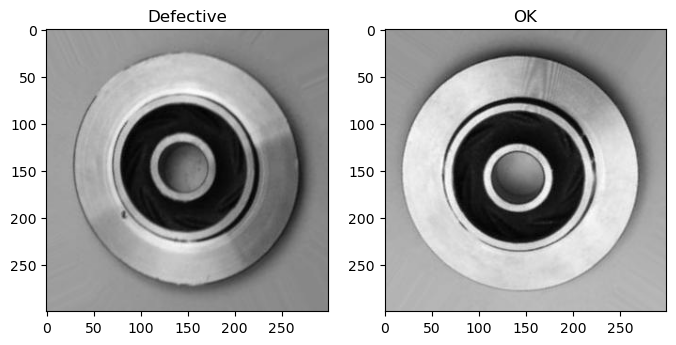

In [2]:
# Ploting images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defective')
axes[1].set_title('OK')
plt.show()

### EDA

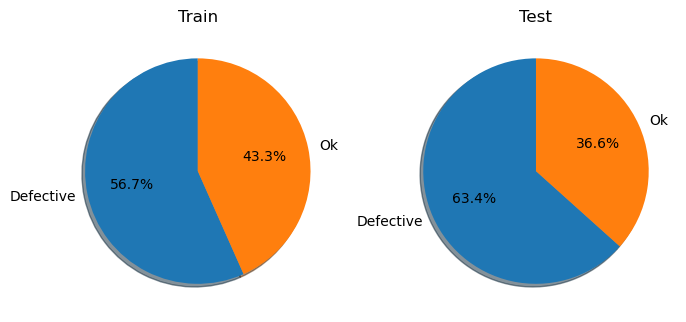

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [3]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
  
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_defective))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_defective))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

In [4]:
train_def = len(os.listdir(train_defective))
train_ok = len(os.listdir(train_ok))
test_def = len(os.listdir(test_defective))
test_ok = len(os.listdir(test_ok))
total_train = [train_def, train_ok]
total_test = [test_def, test_ok]
df = pd.DataFrame(data = [total_train, total_test], columns = ['Defective', 'Non-Defective'], index = ['Train_number','Test_number'])
df

,Defective,Non-Defective
Train_number,3758,2875
Test_number,453,262


<AxesSubplot:>

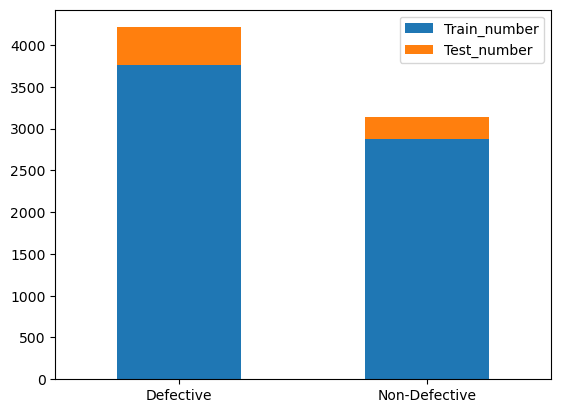

In [5]:
df.T.plot(kind = 'bar', stacked = 'True', rot = 0)


## Data loading and perprocessing

    - 0/1 Normalization 
    - Grayscale
    - input shape resize for CNN (300x300)
    
We normalize the pixel values in the range of 0 to 1. For this, we divide our pixel values by 255.

Resize our images to (300 x 300) , i.e. to grayscale mode.

Set the batch size to 64. Batch size is set because images are trained in batches. This improves the model while training.

Set the class mode to binary, as we only have 2 classes.

Set 30% of our training data as validation data.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using IDG to load images from directory
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30 percent validation split for training 
test_idg = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size = (300, 300)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory='G:/Mtech - Sem 2/Deep Learning/Project/casting_data/train/', subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory='G:/Mtech - Sem 2/Deep Learning/Project/casting_data/train/', subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory='G:/Mtech - Sem 2/Deep Learning/Project/casting_data/test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## ResNet34

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# Residual block
def residual_block(x, filters, strides=(1, 1)):
    y = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    if strides != (1, 1) or x.shape[3] != filters:
        x = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(x)

    y = Add()([x, y])
    y = Activation('relu')(y)
    return y

# Define the ResNet-34 model
def ResNet34(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, strides=(2, 2))
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, strides=(2, 2))
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    x = residual_block(x, 512, strides=(2, 2))
    x = residual_block(x, 512)
    x = residual_block(x, 512)

    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create an instance of the ResNet-34 model
model = ResNet34(input_shape=(img_size[0], img_size[1], 1), num_classes=2)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)

# Train the model
history = model.fit(train, validation_data=valid, epochs=20, callbacks=[checkpoint])


Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.9008 - accuracy: 0.8043  
Epoch 1: val_accuracy improved from -inf to 0.43338, saving model to best_model.h5
73/73 [==============================] - 13863s 191s/step - loss: 0.9008 - accuracy: 0.8043 - val_loss: 149.7412 - val_accuracy: 0.4334
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9490 
Epoch 2: val_accuracy did not improve from 0.43338
73/73 [==============================] - 3859s 53s/step - loss: 0.1390 - accuracy: 0.9490 - val_loss: 16.5078 - val_accuracy: 0.4334
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9587 
Epoch 3: val_accuracy improved from 0.43338 to 0.66616, saving model to best_model.h5
73/73 [==============================] - 4293s 59s/step - loss: 0.1218 - accuracy: 0.9587 - val_loss: 1.3428 - val_accuracy: 0.6662
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9772

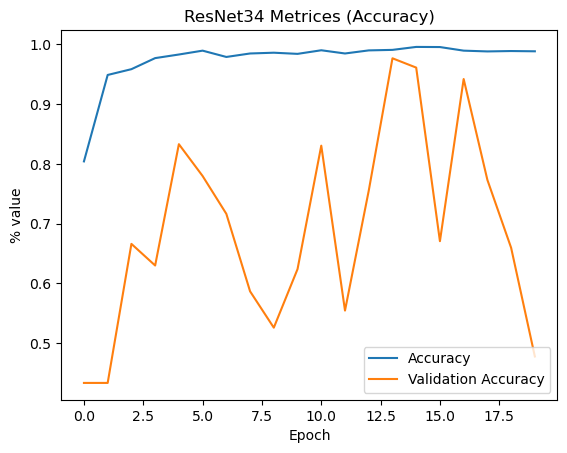

In [8]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet34 Metrices (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

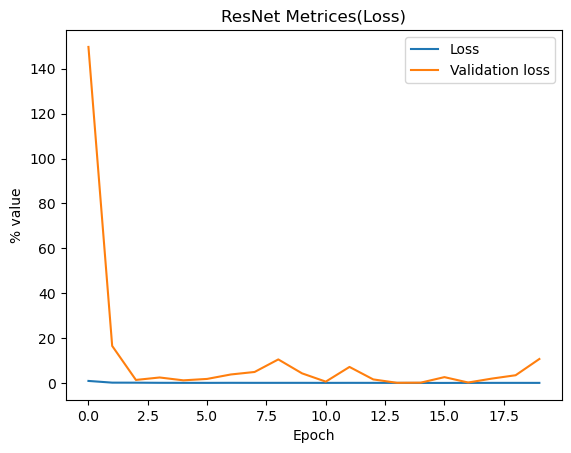

In [9]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('ResNet Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

### Testing and evaluation

In [15]:
y_pred = model.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

12/12 [==============================] - 134s 11s/step - loss: 10.5745 - accuracy: 0.4364
Test Loss: 10.574458122253418
Test Accuracy: 0.4363636374473572
12/12 [==============================] - 134s 11s/step


In [16]:
y_actual = test.classes[test.index_array]

In [26]:
y_true = test.classes[test.index_array]
y_pred = model.predict(test).argmax(axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)



12/12 [==============================] - 140s 11s/step


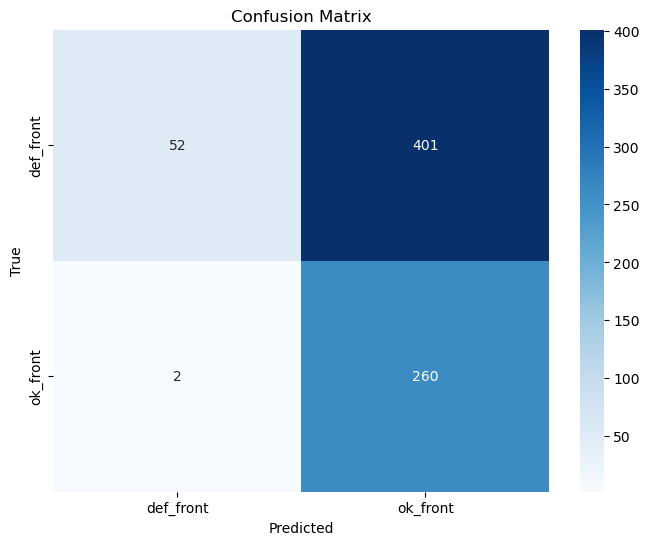

In [19]:
import seaborn as sns
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=test.class_indices, yticklabels=test.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate(test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

12/12 [==============================] - 136s 11s/step - loss: 10.5745 - accuracy: 0.4364
Test Loss: 10.574458122253418
Test Accuracy: 0.4363636374473572


#### Classification report

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9630    0.1148    0.2051       453
           1     0.3933    0.9924    0.5634       262

    accuracy                         0.4364       715
   macro avg     0.6782    0.5536    0.3843       715
weighted avg     0.7542    0.4364    0.3364       715



In [21]:
from tensorflow.keras.models import load_model

# Load the saved best model
best_model = load_model('best_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


12/12 [==============================] - 136s 11s/step - loss: 0.0408 - accuracy: 0.9860
Test Loss: 0.04084973782300949
Test Accuracy: 0.9860140085220337


In [25]:
# Get the predicted labels for the test data
y_pred = best_model.predict(test)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels for the test data
y_true = test.classes

12/12 [==============================] - 139s 12s/step


#### Confusion matrix

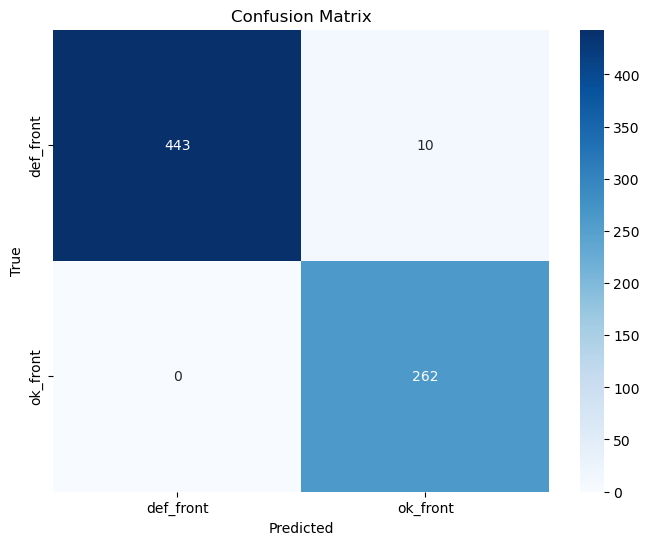

Classification Report:
              precision    recall  f1-score   support

   def_front     1.0000    0.9779    0.9888       453
    ok_front     0.9632    1.0000    0.9813       262

    accuracy                         0.9860       715
   macro avg     0.9816    0.9890    0.9851       715
weighted avg     0.9865    0.9860    0.9861       715



In [24]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=test.class_indices, yticklabels=test.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
target_names = list(test.class_indices.keys())
report = classification_report(y_true, y_pred, digits = 4, target_names=target_names)
print('Classification Report:')
print(report)